In [24]:
import numpy as np
import pandas as pd  
import xarray as xr 
import matplotlib.pyplot as plt 

In [25]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [26]:
def get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    RMSEav = []
    amp_errav  = []
    pha_errav = []
    BCCav = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta)) + np.timedelta64(nmem-1, 'D')
    tend = np.datetime64(str(testyrend)) - np.timedelta64(1, 'D')

    # RMM index in all seasons, amplitudes and phases.
    fnRMM = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    dsrmm0 = xr.open_dataset(fnRMM)
    # delete doy 366
    # dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))

    
    RMMi1 = dsrmm['RMM'][:,0]
    RMMi2 = dsrmm['RMM'][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = './output/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead'+str(leadmjo)+'_dailyinput_mem'+str(nmem)+'d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn['RMMt'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))['RMM'].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC 
        r1p = np.asarray(dsfn_sel['RMMp'][:,0]).reshape((-1, 1))
        r2p = np.asarray(dsfn_sel['RMMp'][:,1]).reshape((-1, 1))

        r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

        # BCC 
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCCav.append(a/b/c) 

        # RMSE [time]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSEav.append(np.sqrt(d))  # RMSE at each time step

        # phase error [time]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_errav.append(d)

        # amplitude error [time] truth - prediction
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_errav.append(c)

        Nsamp = np.shape(dsfn_sel['RMMp_dis'])[1]

        RMSEdp = []
        amp_errdp  = []
        pha_errdp = []
        BCCdp = []

        for idp in range(Nsamp):
            # calculate BCC 
            r1p = np.asarray(dsfn_sel['RMMp_dis'][:,idp,0]).reshape((-1, 1))
            r2p = np.asarray(dsfn_sel['RMMp_dis'][:,idp,1]).reshape((-1, 1))

            # BCC 
            a = np.sum(r1p*r1t+r2p*r2t, axis=0)
            b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
            c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
            BCCdp.append(a/b/c) 

            # RMSE 
            d = np.sqrt((r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p))
            RMSEdp.append(np.mean(d))  

            # phase error 
            a = r1t * r2p - r2t * r1p 
            b = r1t * r1p + r2t * r2p
            c = a / b 
            d = np.arctan(c) * 180. / np.pi
            pha_errdp.append(np.mean(d))

            # amplitude error [time] truth - prediction
            a = np.sqrt(r1p*r1p+r2p*r2p)
            b = np.sqrt(r1t*r1t+r2t*r2t)
            c = b - a 
            amp_errdp.append(np.mean(c))

        BCC.append(BCCdp)
        RMSE.append(RMSEdp)
        amp_err.append(amp_errdp)
        pha_err.append(pha_errdp)
        
        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav

In [27]:
def get_figure(BCCdp, RMSEdp, pha_errdp, amp_errdp, ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].fill_between(lead, np.min(np.asarray(BCCdp),axis=1).squeeze(), np.max(np.asarray(BCCdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, avRMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[0,1].fill_between(lead, np.min(np.asarray(RMSEdp),axis=1).squeeze(), np.max(np.asarray(RMSEdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    ax[0,1].legend(fontsize=12)

    avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, avamperr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,1].fill_between(lead, np.min(np.asarray(amp_errdp),axis=1).squeeze(), np.max(np.asarray(amp_errdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, avphaerr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    ax[1,0].fill_between(lead, np.min(np.asarray(pha_errdp),axis=1).squeeze(), np.max(np.asarray(pha_errdp),axis=1).squeeze(), alpha=.5, linewidth=0)
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    # ax[1,0].legend()

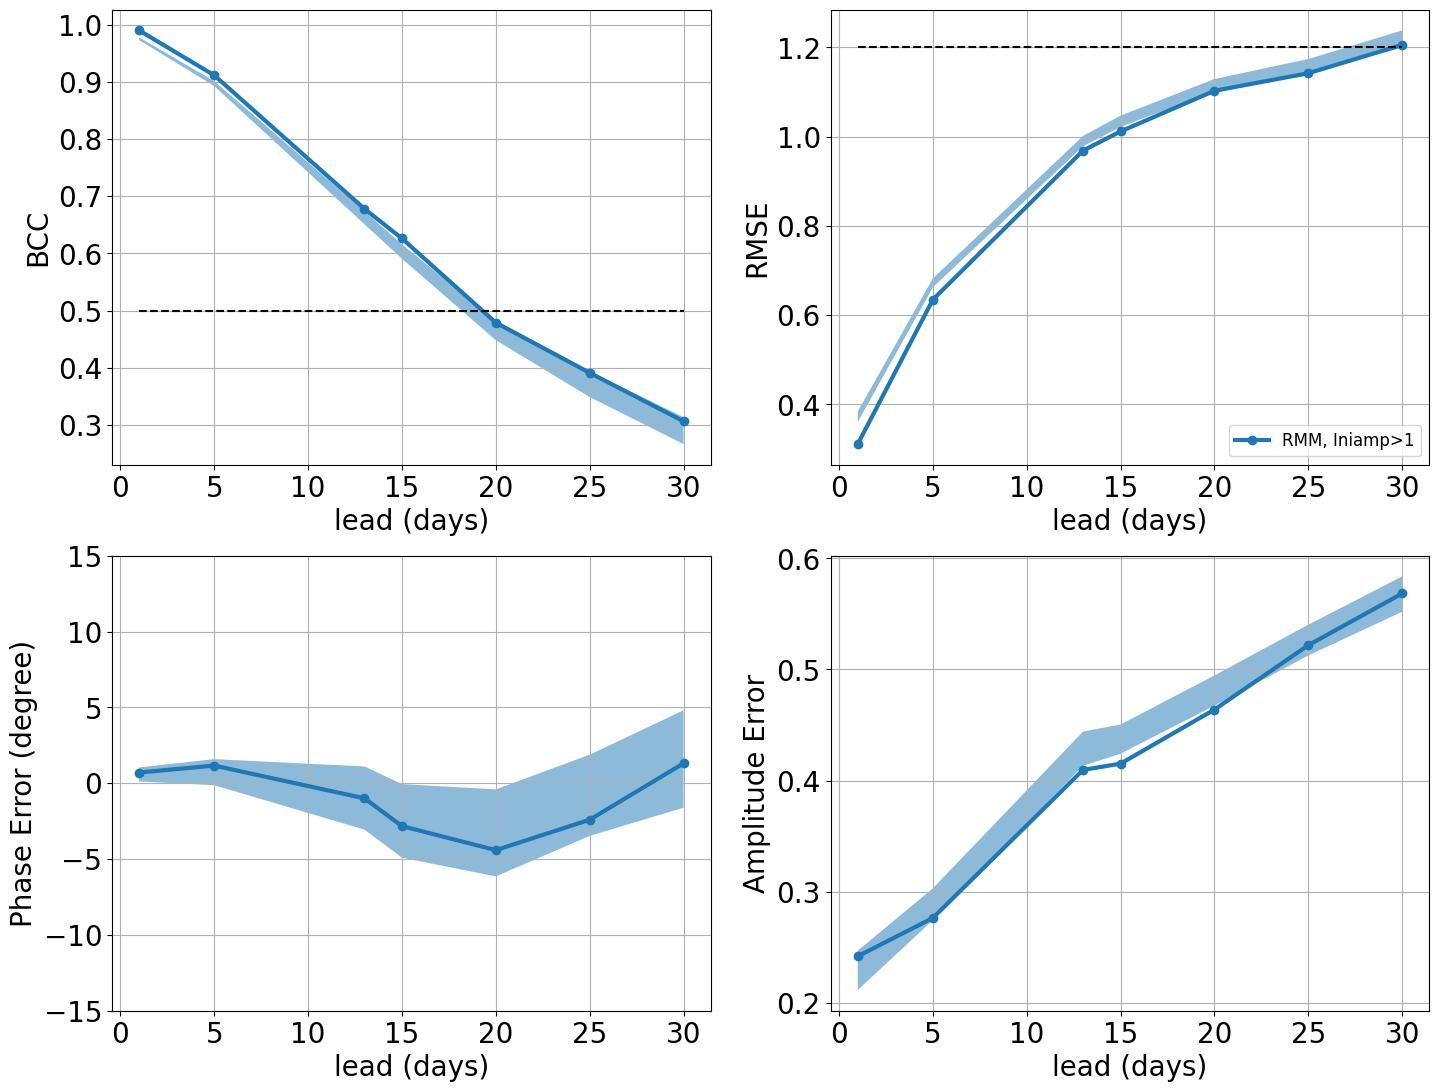

In [28]:
lead = [1, 5, 13, 15, 20, 25, 30]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1
Iniamp0 = 1
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err, BCCav, RMSEav, pha_errav, amp_errav = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure(BCC, RMSE, pha_err, amp_err, ax, lead, BCCav, 'RMM, Iniamp>'+str(Iniamp0), RMSEav, amp_errav, pha_errav)



In [ ]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1
Iniamp0 = 0
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

BCC, RMSE, pha_err, amp_err = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
get_figure(ax, lead, BCC, 'All year, Iniamp>'+str(Iniamp0)+', All Inipha', RMSE, amp_err, pha_err)

In [6]:
# concatenate csv
for ilead, leadmjo in enumerate(lead):
    dst = []  # a list to hold csv files in all testing years at each lead.
    t0 = []  # a list to hold time step
    for iyr, yn in enumerate(np.arange(testyrsta, testyrend)):
        fnt = './old/truth_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead'+str(leadmjo)+'_dailyinput_mem'+str(nmem)+'d'+str(yn)+'.csv'
        dstmp = pd.read_csv(fnt, header=None, index_col=False)
        dst.append(dstmp.copy())

        t0.append(np.arange(np.datetime64(str(yn)), np.datetime64(str(yn))+np.timedelta64(365,'D')))

    ds = pd.concat(dst, ignore_index=True).to_numpy()  # RMM truth [time, 2]
    t = np.concatenate(t0, axis=0)

    RMMt = xr.DataArray(
        data=ds,
        dims=['time','mode'],
        coords=dict(
            time=t,
            mode=[0,1],
        ),
        name='RMMt',
    )

    dsp = []  # a list to hold csv files in all testing years at each lead.
    for iyr, yn in enumerate(np.arange(testyrsta, testyrend)):
        fnp = './old/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead'+str(leadmjo)+'_dailyinput_mem'+str(nmem)+'d'+str(yn)+'.csv'
        dstmp = pd.read_csv(fnp, header=None, index_col=False)
        dsp.append(dstmp.copy())

    ds1 = pd.concat(dsp, ignore_index=True).to_numpy()  # RMM truth [time, 2]

    RMMp = xr.DataArray(
        data=ds1,
        dims=['time','mode'],
        coords=dict(
            time=t,
            mode=[0,1],
        ),
        name='RMMp',
    )

    dsRMM = xr.merge([RMMt, RMMp])
    dsRMM.to_netcdf('/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop/old/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead'+str(leadmjo)+'_dailyinput_mem'+str(nmem)+'d.nc')

    del dsRMM

In [3]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [4]:
def get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta))
    tend = np.datetime64(str(testyrend)) - np.timedelta64(1, 'D')

    # RMM index in all seasons, amplitudes and phases.
    fnRMM = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    dsrmm1 = xr.open_dataset(fnRMM)
    # delete doy 366
    dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))

    
    RMMi1 = dsrmm['RMM'][:,0]
    RMMi2 = dsrmm['RMM'][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = './old/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_lead'+str(leadmjo)+'_dailyinput_mem1d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn['RMMt'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))['RMM'].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC for each MCDO
        r1p = np.asarray(dsfn_sel['RMMp'][:,0]).reshape((-1, 1))
        r2p = np.asarray(dsfn_sel['RMMp'][:,1]).reshape((-1, 1))

        r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

        # # calculate BCC for each MCDO
        # r1p = np.asarray(dsfn_sel['RMMp'][:,0])
        # r2p = np.asarray(dsfn_sel['RMMp'][:,1])

        # r1t = np.asarray(dsfn_sel['RMMt'][:,0])
        # r2t = np.asarray(dsfn_sel['RMMt'][:,1])

        # print(np.shape(r1p))
        # print(np.shape(r2t))

        # BCC  [Nsamp]
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCC.append(a/b/c) 

        # RMSE [time, Nsamp]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE.append(np.sqrt(d))  # RMSE at each time step

        # phase error [time, Nsamp]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_err.append(d)

        # amplitude error [time, Nsamp] truth - prediction
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_err.append(c)

        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err

In [5]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1

BCC, RMSE, pha_err, amp_err = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
BCCw, RMSEw, pha_errw, amp_errw = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[12,1,2,3], Iniamp0=1, Inipha_list=np.arange(1,9))
BCCw2, RMSEw2, pha_errw2, amp_errw2 = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[12,1,2,3], Iniamp0=2, Inipha_list=np.arange(1,9))

In [38]:
BCC0, RMSE0, pha_err0, amp_err0 = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=0, Inipha_list=np.arange(1,9))

In [6]:
def get_figure(ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, avRMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    ax[0,1].legend(fontsize=12)

    avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, avamperr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, avphaerr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    # ax[1,0].legend()

In [40]:
BCCs, RMSEs, pha_errs, amp_errs = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[6,7,8,9], Iniamp0=1, Inipha_list=np.arange(1,9))

In [41]:
BCCs2, RMSEs2, pha_errs2, amp_errs2 = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[6,7,8,9], Iniamp0=2, Inipha_list=np.arange(1,9))

In [42]:
BCCs0, RMSEs0, pha_errs0, amp_errs0 = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[6,7,8,9], Iniamp0=0, Inipha_list=np.arange(1,9))
BCCw0, RMSEw0, pha_errw0, amp_errw0 = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[12,1,2,3], Iniamp0=0, Inipha_list=np.arange(1,9))

In [63]:
# winter - phase
BCCw_pha = []
RMSEw_pha = []
pha_errw_pha = []
amp_errw_pha = []

for ipha in np.arange(1,9):
    a, b, c, d = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[12,1,2,3], Iniamp0=1, Inipha_list=[ipha,])
    BCCw_pha.append(a)
    RMSEw_pha.append(np.mean(b,axis=1))
    pha_errw_pha.append(np.mean(c,axis=1))
    amp_errw_pha.append(np.mean(d,axis=1))
    # print(np.shape(b))


(8, 33, 1)
(8, 52, 1)
(8, 52, 1)
(8, 54, 1)
(8, 46, 1)
(8, 62, 1)
(8, 73, 1)
(8, 40, 1)


In [65]:
# summer - phase
BCCs_pha = []
RMSEs_pha = []
pha_errs_pha = []
amp_errs_pha = []

for ipha in np.arange(1,9):
    a, b, c, d = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[6,7,8,9], Iniamp0=1, Inipha_list=[ipha,])
    BCCs_pha.append(a)
    RMSEs_pha.append(np.mean(b,axis=1))
    pha_errs_pha.append(np.mean(c,axis=1))
    amp_errs_pha.append(np.mean(d,axis=1))

# np.shape(BCCs_pha)

In [69]:
# winter - phase
BCCw0_pha = []
RMSEw0_pha = []
pha_errw0_pha = []
amp_errw0_pha = []

for ipha in np.arange(1,9):
    a, b, c, d = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[12,1,2,3], Iniamp0=0, Inipha_list=[ipha,])
    BCCw0_pha.append(a)
    RMSEw0_pha.append(np.mean(b,axis=1))
    pha_errw0_pha.append(np.mean(c,axis=1))
    amp_errw0_pha.append(np.mean(d,axis=1))

# summer - phase
BCCs0_pha = []
RMSEs0_pha = []
pha_errs0_pha = []
amp_errs0_pha = []

for ipha in np.arange(1,9):
    a, b, c, d = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[6,7,8,9], Iniamp0=0, Inipha_list=[ipha,])
    BCCs0_pha.append(a)
    RMSEs0_pha.append(np.mean(b,axis=1))
    pha_errs0_pha.append(np.mean(c,axis=1))
    amp_errs0_pha.append(np.mean(d,axis=1))

Text(0, 0.5, 'Initial Phase')

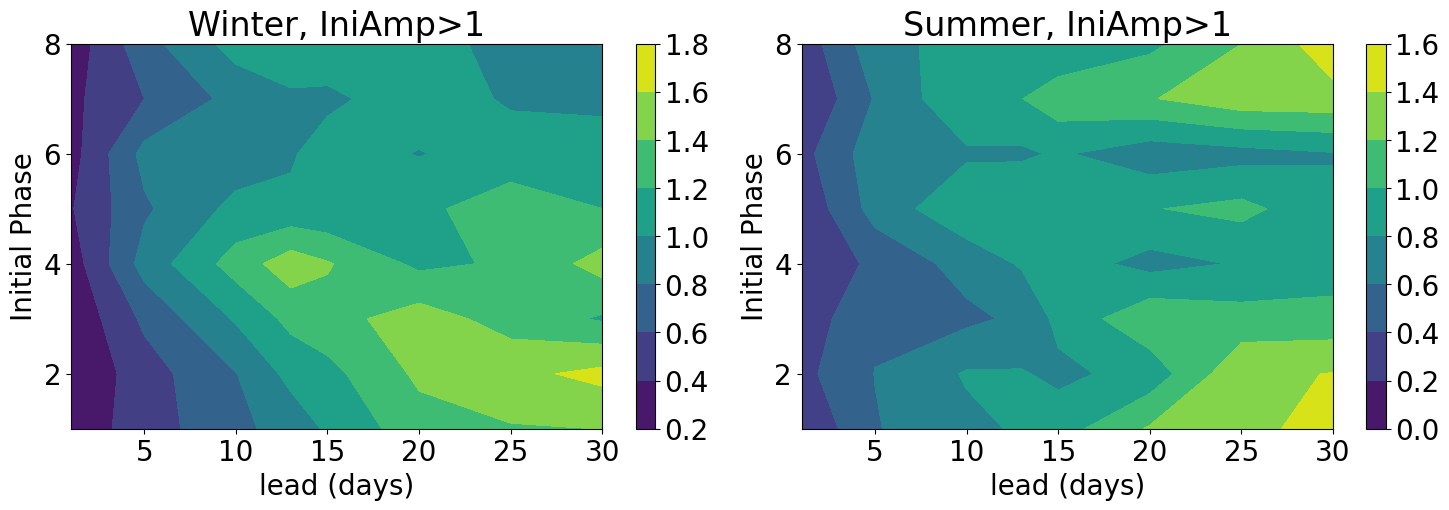

In [76]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1, 2, hspace=0.4, wspace=0.1)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

# tmp = np.asarray(RMSEw0_pha).squeeze()
# im = ax[0].contourf(lead, np.arange(1,9),tmp)
# plt.colorbar(im, ax=ax[0])
# ax[0].set_title('Winter, IniAmp>0')
# ax[0].set_xlabel('lead (days)')
# ax[0].set_ylabel('Initial Phase')

# tmp = np.asarray(RMSEs0_pha).squeeze()
# im = ax[1].contourf(lead, np.arange(1,9),tmp)
# plt.colorbar(im, ax=ax[1])
# ax[1].set_title('Summer, IniAmp>0')
# ax[1].set_xlabel('lead (days)')
# ax[1].set_ylabel('Initial Phase')

tmp = np.asarray(RMSEw_pha).squeeze()
im = ax[0].contourf(lead, np.arange(1,9),tmp)
# ax[0].contourf(lead, np.arange(1,9),tmp,[1.2])
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Winter, IniAmp>1')
ax[0].set_xlabel('lead (days)')
ax[0].set_ylabel('Initial Phase')

tmp = np.asarray(RMSEs_pha).squeeze()
im = ax[1].contourf(lead, np.arange(1,9),tmp)
# ax[1].contourf(lead, np.arange(1,9),tmp,[1.2])
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Summer, IniAmp>1')
ax[1].set_xlabel('lead (days)')
ax[1].set_ylabel('Initial Phase')

# tmp = np.asarray(BCCw_pha).squeeze()
# im = ax[0].contourf(lead, np.arange(1,9),tmp)
# ax[0].contour(lead, np.arange(1,9),tmp,[0.5])
# plt.colorbar(im, ax=ax[0])
# ax[0].set_title('Winter, IniAmp>1')
# ax[0].set_xlabel('lead (days)')
# ax[0].set_ylabel('Initial Phase')

# tmp = np.asarray(BCCs_pha).squeeze()
# im = ax[1].contourf(lead, np.arange(1,9),tmp)
# ax[1].contour(lead, np.arange(1,9),tmp,[0.5])
# plt.colorbar(im, ax=ax[1])
# ax[1].set_title('Summer, IniAmp>1')
# ax[1].set_xlabel('lead (days)')
# ax[1].set_ylabel('Initial Phase')

In [45]:
def get_histogram(ax, lead, i, label_flg, RMSE, amp_err, pha_err):
    ax[0].hist(RMSE[i], bins= 20, range=(0,3.5), density=True) #'All year, Iniamp>1, All Inipha')
    ax[0].set_xlabel('RMSE')
    ax[0].set_ylabel('density')

    ax[1].hist(amp_err[i], bins= 20, range=(-3,3), density=True) #'All year, Iniamp>1, All Inipha')
    ax[1].set_xlabel('Amplitude Error')
    ax[1].set_ylabel('density')
    ax[1].set_title(label_flg+' lead='+str(lead[i]))

    ax[2].hist(pha_err[i], bins= 20, range=(-90,90), density=True) #'All year, Iniamp>1, All Inipha')
    ax[2].set_xlabel('Phase Error')
    ax[2].set_ylabel('density')




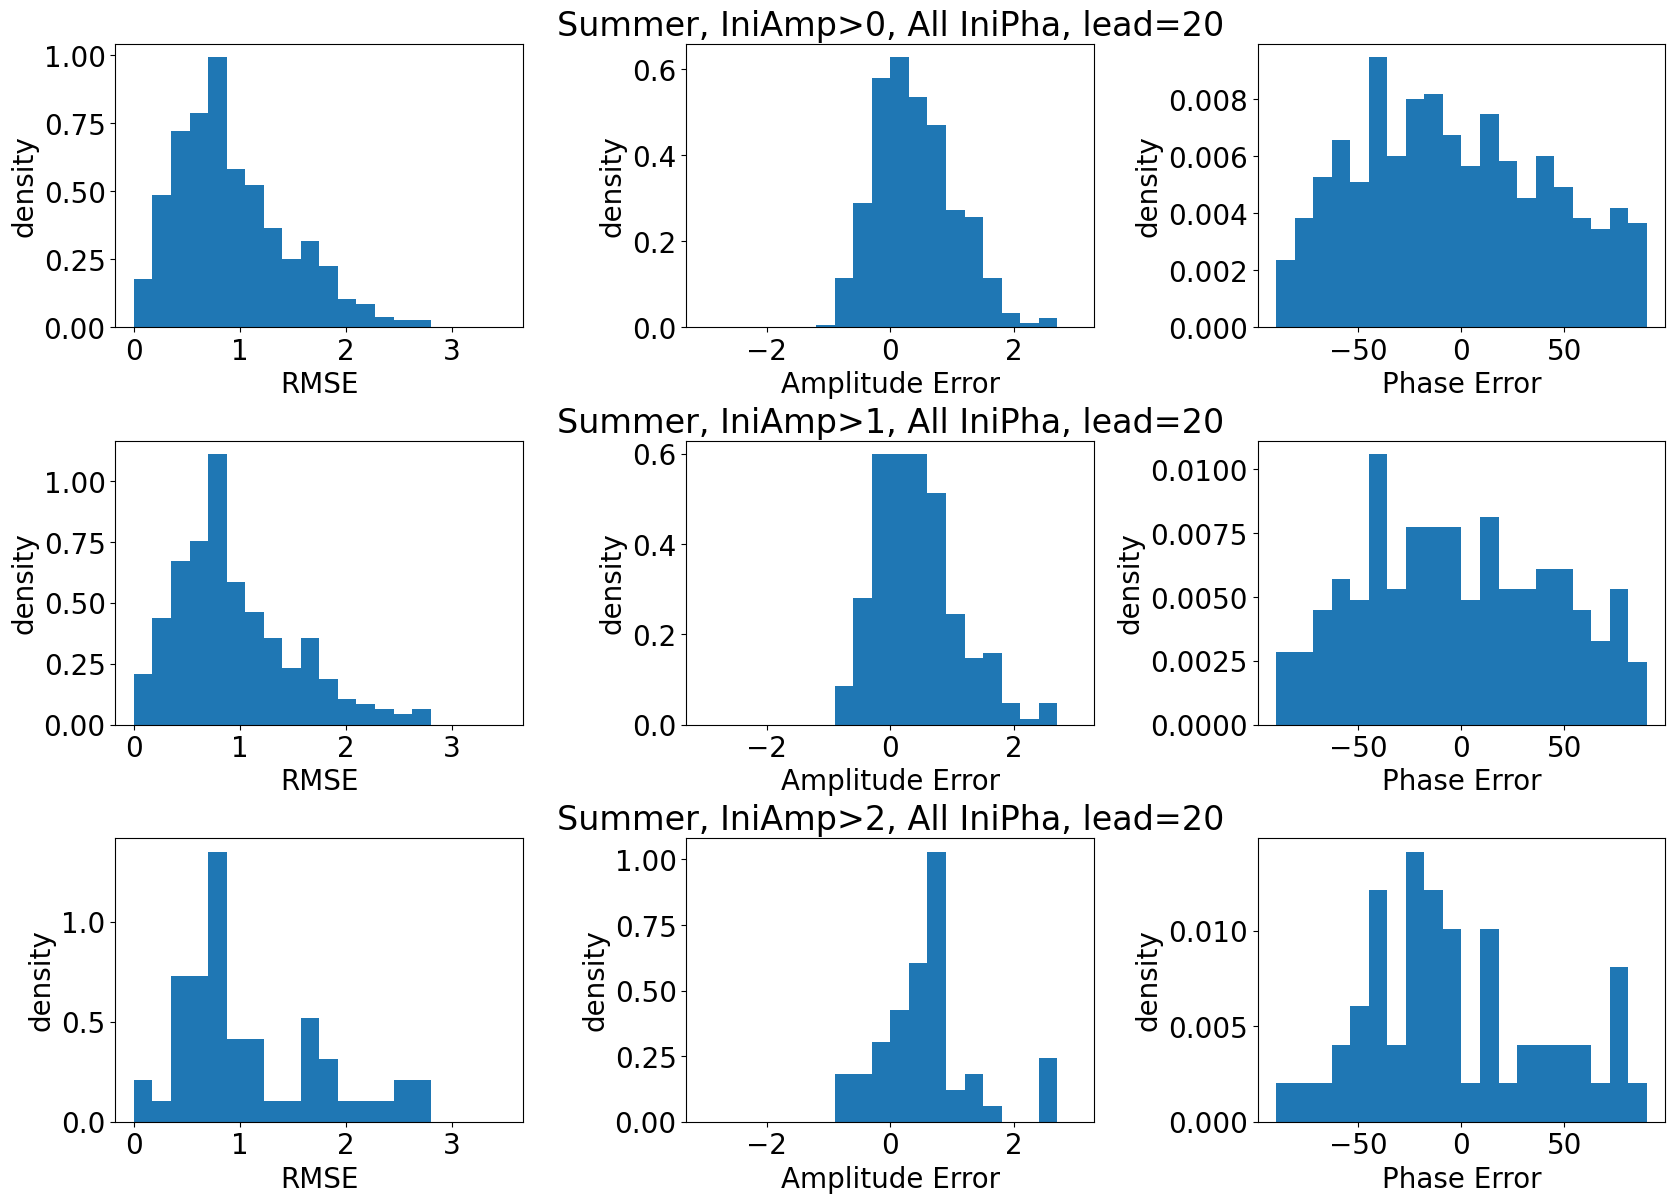

In [47]:
# plot histgram of RMSE for each case
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})
# get_histogram(ax[0,:], lead, 'All year, IniAmp>1, All IniPha,', RMSE, amp_err, pha_err)
# get_histogram(ax[1,:], lead, 'Winter, IniAmp>1, All IniPha,', RMSEw, amp_errw, pha_errw)
# get_histogram(ax[2,:], lead, 'Summer, IniAmp>1, All IniPha,', RMSEs, amp_errs, pha_errs)

# i = 2
i = 5
get_histogram(ax[0,:], lead, i, 'Summer, IniAmp>0, All IniPha,', RMSEs0, amp_errs0, pha_errs0)
get_histogram(ax[1,:], lead, i, 'Summer, IniAmp>1, All IniPha,', RMSEs, amp_errs, pha_errs)
get_histogram(ax[2,:], lead, i, 'Summer, IniAmp>2, All IniPha,', RMSEs2, amp_errs2, pha_errs2)
# i = 5
# get_histogram(ax[0,:], lead, i, 'Winter, IniAmp>0, All IniPha,', RMSEw0, amp_errw0, pha_errw0)
# get_histogram(ax[1,:], lead, i, 'Winter, IniAmp>1, All IniPha,', RMSEw, amp_errw, pha_errw)
# get_histogram(ax[2,:], lead, i, 'Winter, IniAmp>2, All IniPha,', RMSEw2, amp_errw2, pha_errw2)

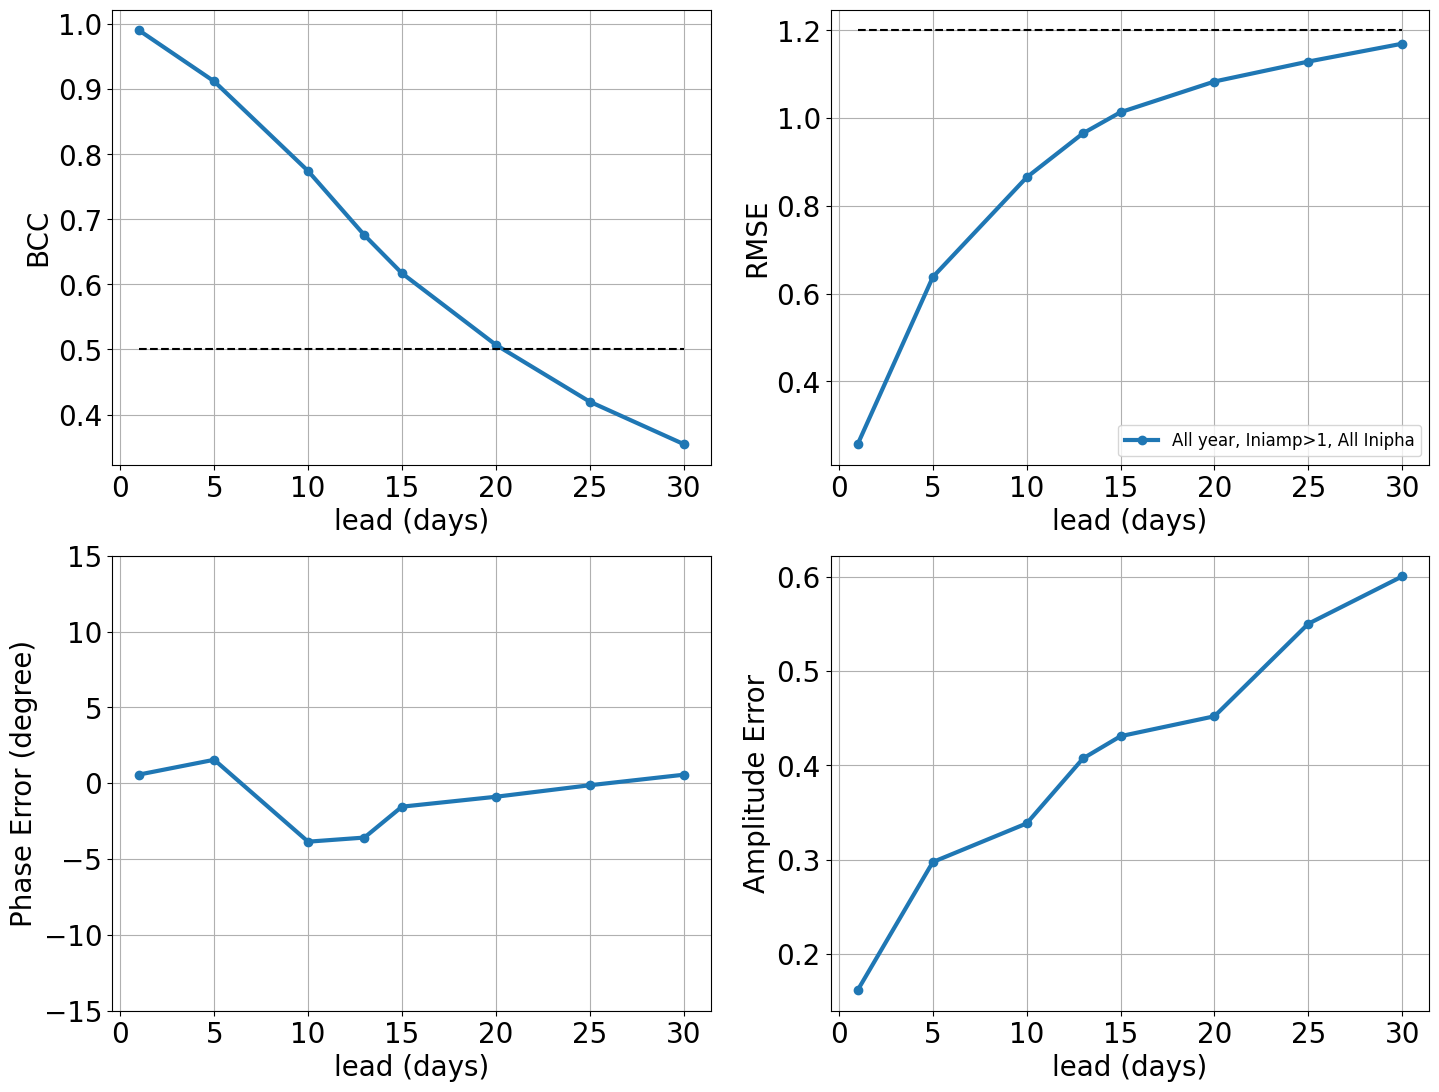

In [7]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

# get_figure(ax, lead, BCCw0, 'winter, Iniamp>0, All Inipha', RMSEw0, amp_errw0, pha_errw0)
# get_figure(ax, lead, BCCs0, 'summer, Iniamp>0, All Inipha', RMSEs0, amp_errs0, pha_errs0)

# get_figure(ax, lead, BCC0, 'All year, Iniamp>0, All Inipha', RMSE0, amp_err0, pha_err0)
get_figure(ax, lead, BCC, 'All year, Iniamp>1, All Inipha', RMSE, amp_err, pha_err)
# get_figure(ax, lead, BCCw, 'winter, Iniamp>1, All Inipha', RMSEw, amp_errw, pha_errw)
# get_figure(ax, lead, BCCs, 'summer, Iniamp>1, All Inipha', RMSEs, amp_errs, pha_errs)
# get_figure(ax, lead, BCCw2, 'winter, Iniamp>2, All Inipha', RMSEw2, amp_errw2, pha_errw2)
# get_figure(ax, lead, BCCs2, 'summer, Iniamp>2, All Inipha', RMSEs2, amp_errs2, pha_errs2)